# Data Analysis for FD001

In [230]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import plotly.express as px
from statsmodels.nonparametric.smoothers_lowess import lowess

## Data Preprocessing

In [231]:
train_data_df = pd.read_csv('../../TED/CMAPSSData/train_FD001.txt', sep=' ', header = None)
test_data_df = pd.read_csv('../../TED/CMAPSSData/test_FD001.txt', sep=' ', header = None)
test_labels_at_break_df = pd.read_csv('../../TED/CMAPSSData/RUL_FD001.txt', sep=' ', header = None)

train_data_df.drop(train_data_df.columns[[-1, -2]], axis=1, inplace=True)
test_data_df.drop(test_data_df.columns[[-1, -2]], axis=1, inplace=True)
test_labels_at_break_df.drop(test_labels_at_break_df.columns[[-1]], axis=1, inplace=True)

### Extracting labels and organising the data

In [232]:
column_names = ['ID', 'Cycle', 'OpSet1', 'OpSet2', 'OpSet3', 'SensorMeasure1', 'SensorMeasure2', 'SensorMeasure3', 'SensorMeasure4', 'SensorMeasure5', 'SensorMeasure6', 'SensorMeasure7', 'SensorMeasure8', 'SensorMeasure9', 'SensorMeasure10', 'SensorMeasure11', 'SensorMeasure12', 'SensorMeasure13', 'SensorMeasure14', 'SensorMeasure15', 'SensorMeasure16', 'SensorMeasure17', 'SensorMeasure18', 'SensorMeasure19', 'SensorMeasure20', 'SensorMeasure21']

train_data_df.columns = column_names
max_cycles_train_df = train_data_df.groupby(['ID'], sort=False)['Cycle'].max().reset_index().rename(columns={'Cycle':'MaxCycleID'})

train_data_df = pd.merge(train_data_df, max_cycles_train_df, how='inner', on='ID')
train_data_df['RUL'] = train_data_df['MaxCycleID'] - train_data_df['Cycle']
train_data_df.drop(columns=['MaxCycleID'], inplace=True)

test_data_df.columns = column_names
max_cycles_test_df = test_data_df.groupby(['ID'], sort=False)['Cycle'].max().reset_index().rename(columns={'Cycle':'MaxCycleID'})

test_labels_at_break_df.columns = ['RUL']
test_labels_at_break_df['ID'] = max_cycles_test_df['ID']
test_labels_at_break_df['RUL'] = test_labels_at_break_df['RUL'] + max_cycles_test_df['MaxCycleID']

test_data_df = pd.merge(test_data_df, test_labels_at_break_df, how='inner', on='ID')
test_data_df['RUL'] = test_data_df['RUL'] - test_data_df['Cycle']

In [233]:
train_labels_df = train_data_df['RUL']
test_labels_df = test_data_df['RUL']
train_labels_at_break_df = train_data_df.groupby('ID').last().reset_index()['RUL']

### Divide by engine

In [234]:
train_groupby = train_data_df.groupby(['ID'], sort=False)
test_groupby = test_data_df.groupby(['ID'], sort=False)

### Graphs: Data before analysed

In [235]:
sensor_names = []
for i in range(3):
    sensor_names.append('OpSet' + str(i+1))
for i in range(21):
    sensor_names.append('SensorMeasure' + str(i+1))

In [236]:
def divide_by_engine(df_groupby):

    groupby_arr = []
    for i in range(len(df_groupby)):
        groupby_arr.append(df_groupby.get_group(i+1))

    for i in range(len(df_groupby)):
        groupby_arr[i] = groupby_arr[i].to_numpy()

    return groupby_arr

In [237]:
def plot_by_engine(train_gb, rows, names, filename):

    train_groupby_arr = divide_by_engine(train_gb)

    fig, axs = plt.subplots(rows, 4)
    flat_axs = axs.flatten()
    for sensor in range(len(names)):
        flat_axs[sensor].set_title(names[sensor])
        for engine in range(len(train_groupby_arr)):
            flat_axs[sensor].plot(train_groupby_arr[engine][:, 1], train_groupby_arr[engine][:, sensor + 2])

    plt.setp(axs[-1, :], xlabel='Cycles')
    plt.setp(axs[:, 0], ylabel='Sensor readings')
    fig.set_size_inches(20, 30) 
    plt.savefig(filename)
    plt.show()

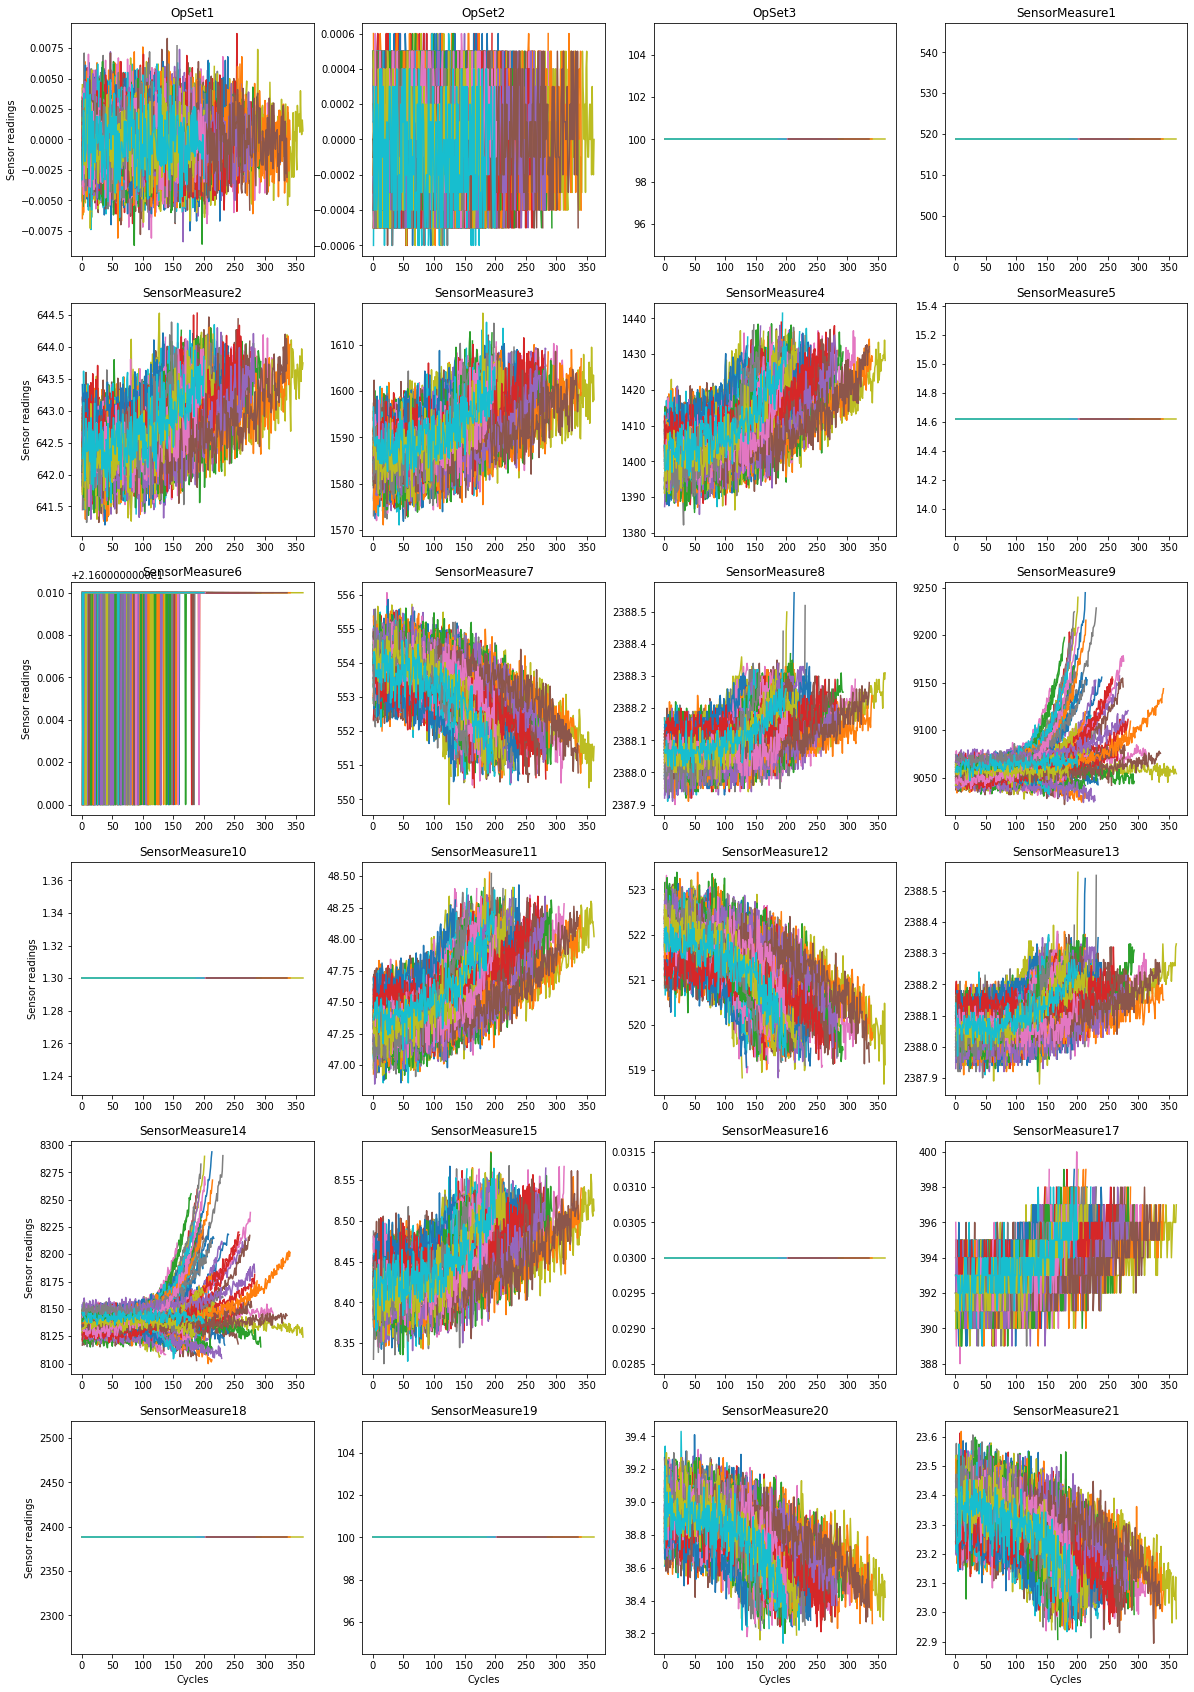

In [238]:
plot_by_engine(train_groupby, 6, sensor_names, 'fd001-sensors_unprocessed.jpg')

From the graph, we can see which sensors will have a greater impact on the performance of the regressor, and which are irrelevant for this task. I decided to take Sensors: 1, 5, 6, 10, 16, 18, 19

### Taking away all non-important sensors

In [239]:
sensors_used = []
sensors_used.append('ID')
sensors_used.append('Cycle')
for i in range(1, 22):
    if i not in [1, 5, 6, 10, 16, 18, 19]:
        sensors_used.append("SensorMeasure" + str(i))

In [240]:
train_data_df = train_data_df[sensors_used]
train_grouppby = train_data_df.groupby(['ID'], sort=False)
test_groupby = test_data_df.groupby(['ID'], sort=False)

In [241]:
train_data_df

ID  Cycle  SensorMeasure2  SensorMeasure3  SensorMeasure4  \
0        1      1          641.82         1589.70         1400.60   
1        1      2          642.15         1591.82         1403.14   
2        1      3          642.35         1587.99         1404.20   
3        1      4          642.35         1582.79         1401.87   
4        1      5          642.37         1582.85         1406.22   
...    ...    ...             ...             ...             ...   
20626  100    196          643.49         1597.98         1428.63   
20627  100    197          643.54         1604.50         1433.58   
20628  100    198          643.42         1602.46         1428.18   
20629  100    199          643.23         1605.26         1426.53   
20630  100    200          643.85         1600.38         1432.14   

       SensorMeasure7  SensorMeasure8  SensorMeasure9  SensorMeasure11  \
0              554.36         2388.06         9046.19            47.47   
1              553.75         2388.04         9044.07            47.49   
2              554.26         2388.08         9052.94            47.27   
3              554.45         2388.11         9049.48            47.13   
4              554.00         2388.06         9055.15            47.28   
...               ...             ...             ...              ...   
20626          551.43         2388.19         9065.52            48.07   
20627          550.86         2388.23         9065.11            48.04   
20628          550.94         2388.24         9065.90            48.09   
20629          550.68         2388.25         9073.72            48.39   
20630          550.79         2388.26         9061.48            48.20   

       SensorMeasure12  SensorMeasure13  SensorMeasure14  SensorMeasure15  \
0               521.66          2388.02          8138.62           8.4195   
1               522.28          2388.07          8131.49           8.4318   
2               522.42          2388.03          8133.23           8.4178   
3               522.86          2388.08          8133.83           8.3682   
4               522.19          2388.04          8133.80           8.4294   
...                ...              ...              ...              ...   
20626           519.49          2388.26          8137.60           8.4956   
20627           519.68          2388.22          8136.50           8.5139   
20628           520.01          2388.24          8141.05           8.5646   
20629           519.67          2388.23          8139.29           8.5389   
20630           519.30          2388.26          8137.33           8.5036   

       SensorMeasure17  SensorMeasure20  SensorMeasure21  
0                  392            39.06          23.4190  
1                  392            39.00          23.4236  
2                  390            38.95          23.3442  
3                  392            38.88          23.3739  
4                  393            38.90          23.4044  
...                ...              ...              ...  
20626              397            38.49          22.9735  
20627              395            38.30          23.1594  
20628              398            38.44          22.9333  
20629              395            38.29          23.0640  
20630              396            38.37          23.0522  

[20631 rows x 16 columns]

### Principal Component Analysis

In [242]:
train_data_df.shape
ms_used = sensors_used[2:]

In [243]:
sc = StandardScaler()
scaled_values = sc.fit_transform(train_data_df.values[:, 2:])

pca = PCA(n_components = 0.95)
pca_values = pca.fit_transform(scaled_values)

Number of components: 10


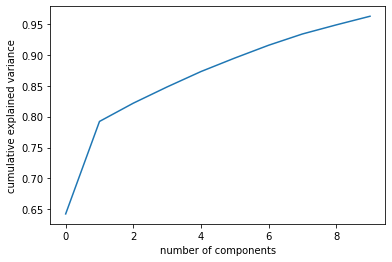

In [244]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
print("Number of components: " + str(pca.n_components_))

In [245]:
pd.DataFrame(pca.components_, columns = ms_used)

SensorMeasure2  SensorMeasure3  SensorMeasure4  SensorMeasure7  \
0        0.273312        0.260226        0.301180       -0.298388   
1        0.017252        0.076255        0.009438        0.052614   
2       -0.188164        0.934610       -0.035114        0.029302   
3       -0.555712        0.080832       -0.031256       -0.010412   
4        0.736466        0.165550       -0.092851        0.092436   
5       -0.075867       -0.047968       -0.016107       -0.013383   
6       -0.091450       -0.054859        0.067223       -0.059406   
7       -0.142392       -0.113957        0.313673       -0.355600   
8       -0.040444       -0.007999        0.347706        0.844858   
9       -0.010238       -0.003818       -0.714389       -0.018240   

   SensorMeasure8  SensorMeasure9  SensorMeasure11  SensorMeasure12  \
0        0.281721        0.105860         0.309274        -0.304419   
1       -0.244497        0.643777        -0.016087         0.063154   
2       -0.020464       -0.046404        -0.034067         0.021017   
3        0.003153       -0.041950        -0.033372         0.026342   
4       -0.043611       -0.056511        -0.066082         0.059972   
5        0.014785        0.016570         0.009296        -0.021793   
6        0.066555        0.039873         0.028040        -0.052320   
7        0.211648        0.144672         0.163062        -0.193234   
8        0.250546        0.073811         0.032306        -0.030274   
9        0.447150        0.170593        -0.031848         0.157328   

   SensorMeasure13  SensorMeasure14  SensorMeasure15  SensorMeasure17  \
0         0.281340         0.066410         0.287067         0.269290   
1        -0.246284         0.666837         0.020762         0.077244   
2        -0.022673        -0.041474        -0.077451        -0.250434   
3         0.004664        -0.041582        -0.032411         0.812985   
4        -0.039202        -0.049646        -0.182594         0.396625   
5         0.022694         0.009047        -0.111320        -0.068275   
6         0.047251         0.037280         0.745646        -0.118040   
7         0.216001         0.134603        -0.550700        -0.144924   
8         0.293913         0.065942        -0.043959        -0.001737   
9         0.452362         0.166608        -0.010871        -0.026990   

   SensorMeasure20  SensorMeasure21  
0        -0.282764        -0.283727  
1        -0.018033        -0.022464  
2         0.099463         0.063165  
3         0.111122         0.062403  
4         0.405921         0.201397  
5         0.580687        -0.797247  
6         0.543681         0.319223  
7         0.309734         0.356735  
8         0.019210         0.019901  
9        -0.022704         0.025169

In [246]:
n_pcs = pca.n_components_
most_important = [np.abs(pca.components_[i]).argmax() for i in range(n_pcs)]
initial_feature_names = ms_used
most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]

print(most_important_names)

['SensorMeasure11', 'SensorMeasure14', 'SensorMeasure3', 'SensorMeasure17', 'SensorMeasure2', 'SensorMeasure21', 'SensorMeasure15', 'SensorMeasure15', 'SensorMeasure7', 'SensorMeasure4']


In [247]:
fig = px.scatter_3d(pca_values, x=0, y=1, z=2, color=train_data_df['ID'])
fig.show()
fig.write_html("fd001-PCA-3d_plot.html")

Sensors 2, 3, 4, 7, 11, 14, 15, 17, 21 contain 90% of the variance, and therefore will be the most useful sensors to use.

In [248]:
train_data_df.to_csv('./fd001-raw_train.csv', sep=' ', columns=train_data_df.columns, index=False)
test_data_df[train_data_df.columns].to_csv('./fd001-raw_test.csv', sep=' ', columns=train_data_df.columns, index=False)

In [249]:
train_labels_df.to_csv('./fd001-training_labels.csv', sep=' ', columns=['RUL'], index=False)
test_labels_df.to_csv('./fd001-testing_labels.csv', sep=' ', columns=['RUL'], index=False)
train_labels_at_break_df.to_csv('./fd001-testing_labels_at_break.csv', sep=' ', columns=['RUL'], index=False)

### Scaling and Normalising Data

In [250]:
train_data_df

ID  Cycle  SensorMeasure2  SensorMeasure3  SensorMeasure4  \
0        1      1          641.82         1589.70         1400.60   
1        1      2          642.15         1591.82         1403.14   
2        1      3          642.35         1587.99         1404.20   
3        1      4          642.35         1582.79         1401.87   
4        1      5          642.37         1582.85         1406.22   
...    ...    ...             ...             ...             ...   
20626  100    196          643.49         1597.98         1428.63   
20627  100    197          643.54         1604.50         1433.58   
20628  100    198          643.42         1602.46         1428.18   
20629  100    199          643.23         1605.26         1426.53   
20630  100    200          643.85         1600.38         1432.14   

       SensorMeasure7  SensorMeasure8  SensorMeasure9  SensorMeasure11  \
0              554.36         2388.06         9046.19            47.47   
1              553.75         2388.04         9044.07            47.49   
2              554.26         2388.08         9052.94            47.27   
3              554.45         2388.11         9049.48            47.13   
4              554.00         2388.06         9055.15            47.28   
...               ...             ...             ...              ...   
20626          551.43         2388.19         9065.52            48.07   
20627          550.86         2388.23         9065.11            48.04   
20628          550.94         2388.24         9065.90            48.09   
20629          550.68         2388.25         9073.72            48.39   
20630          550.79         2388.26         9061.48            48.20   

       SensorMeasure12  SensorMeasure13  SensorMeasure14  SensorMeasure15  \
0               521.66          2388.02          8138.62           8.4195   
1               522.28          2388.07          8131.49           8.4318   
2               522.42          2388.03          8133.23           8.4178   
3               522.86          2388.08          8133.83           8.3682   
4               522.19          2388.04          8133.80           8.4294   
...                ...              ...              ...              ...   
20626           519.49          2388.26          8137.60           8.4956   
20627           519.68          2388.22          8136.50           8.5139   
20628           520.01          2388.24          8141.05           8.5646   
20629           519.67          2388.23          8139.29           8.5389   
20630           519.30          2388.26          8137.33           8.5036   

       SensorMeasure17  SensorMeasure20  SensorMeasure21  
0                  392            39.06          23.4190  
1                  392            39.00          23.4236  
2                  390            38.95          23.3442  
3                  392            38.88          23.3739  
4                  393            38.90          23.4044  
...                ...              ...              ...  
20626              397            38.49          22.9735  
20627              395            38.30          23.1594  
20628              398            38.44          22.9333  
20629              395            38.29          23.0640  
20630              396            38.37          23.0522  

[20631 rows x 16 columns]

In [251]:
sc = StandardScaler()
for sensor in ms_used:
    train_data_df.loc[:,sensor] = sc.fit_transform(train_data_df[sensor].values.reshape(-1, 1))
    test_data_df.loc[:,sensor] = sc.fit_transform(test_data_df[sensor].values.reshape(-1, 1))

/opt/homebrew/lib/python3.9/site-packages/pandas/core/indexing.py:1835: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/homebrew/lib/python3.9/site-packages/pandas/core/indexing.py:1835: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/homebrew/lib/python3.9/site-packages/pandas/core/indexing.py:1835: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.p

In [252]:
train_data_df

ID  Cycle  SensorMeasure2  SensorMeasure3  SensorMeasure4  \
0        1      1       -1.721725       -0.134255       -0.925936   
1        1      2       -1.061780        0.211528       -0.643726   
2        1      3       -0.661813       -0.413166       -0.525953   
3        1      4       -0.661813       -1.261314       -0.784831   
4        1      5       -0.621816       -1.251528       -0.301518   
...    ...    ...             ...             ...             ...   
20626  100    196        1.618000        1.216258        2.188375   
20627  100    197        1.717992        2.279706        2.738351   
20628  100    198        1.478011        1.946971        2.138377   
20629  100    199        1.098043        2.403666        1.955051   
20630  100    200        2.337940        1.607712        2.578358   

       SensorMeasure7  SensorMeasure8  SensorMeasure9  SensorMeasure11  \
0            1.121141       -0.516338       -0.862813        -0.266467   
1            0.431930       -0.798093       -0.958818        -0.191583   
2            1.008155       -0.234584       -0.557139        -1.015303   
3            1.222827        0.188048       -0.713826        -1.539489   
4            0.714393       -0.516338       -0.457059        -0.977861   
...               ...             ...             ...              ...   
20626       -2.189329        1.315066        0.012547         1.980044   
20627       -2.833345        1.878576       -0.006020         1.867718   
20628       -2.742957        2.019453        0.029755         2.054927   
20629       -3.036719        2.160330        0.383884         3.178182   
20630       -2.912435        2.301208       -0.170405         2.466787   

       SensorMeasure12  SensorMeasure13  SensorMeasure14  SensorMeasure15  \
0             0.334262        -1.058890        -0.269071        -0.603816   
1             1.174899        -0.363646        -0.642845        -0.275852   
2             1.364721        -0.919841        -0.551629        -0.649144   
3             1.961302        -0.224597        -0.520176        -1.971665   
4             1.052871        -0.780793        -0.521748        -0.339845   
...                ...              ...              ...              ...   
20626        -2.607969         2.278282        -0.322542         1.425294   
20627        -2.350355         1.722087        -0.380207         1.913240   
20628        -1.902919         2.000184        -0.141684         3.265092   
20629        -2.363913         1.861136        -0.233948         2.579834   
20630        -2.865584         2.278282        -0.336696         1.638604   

       SensorMeasure17  SensorMeasure20  SensorMeasure21  
0            -0.781710         1.348493         1.194427  
1            -0.781710         1.016528         1.236922  
2            -2.073094         0.739891         0.503423  
3            -0.781710         0.352598         0.777792  
4            -0.136018         0.463253         1.059552  
...                ...              ...              ...  
20626         2.446751        -1.805173        -2.921113  
20627         1.155367        -2.856395        -1.203764  
20628         3.092444        -2.081810        -3.292481  
20629         1.155367        -2.911722        -2.085072  
20630         1.801059        -2.469103        -2.194080  

[20631 rows x 16 columns]

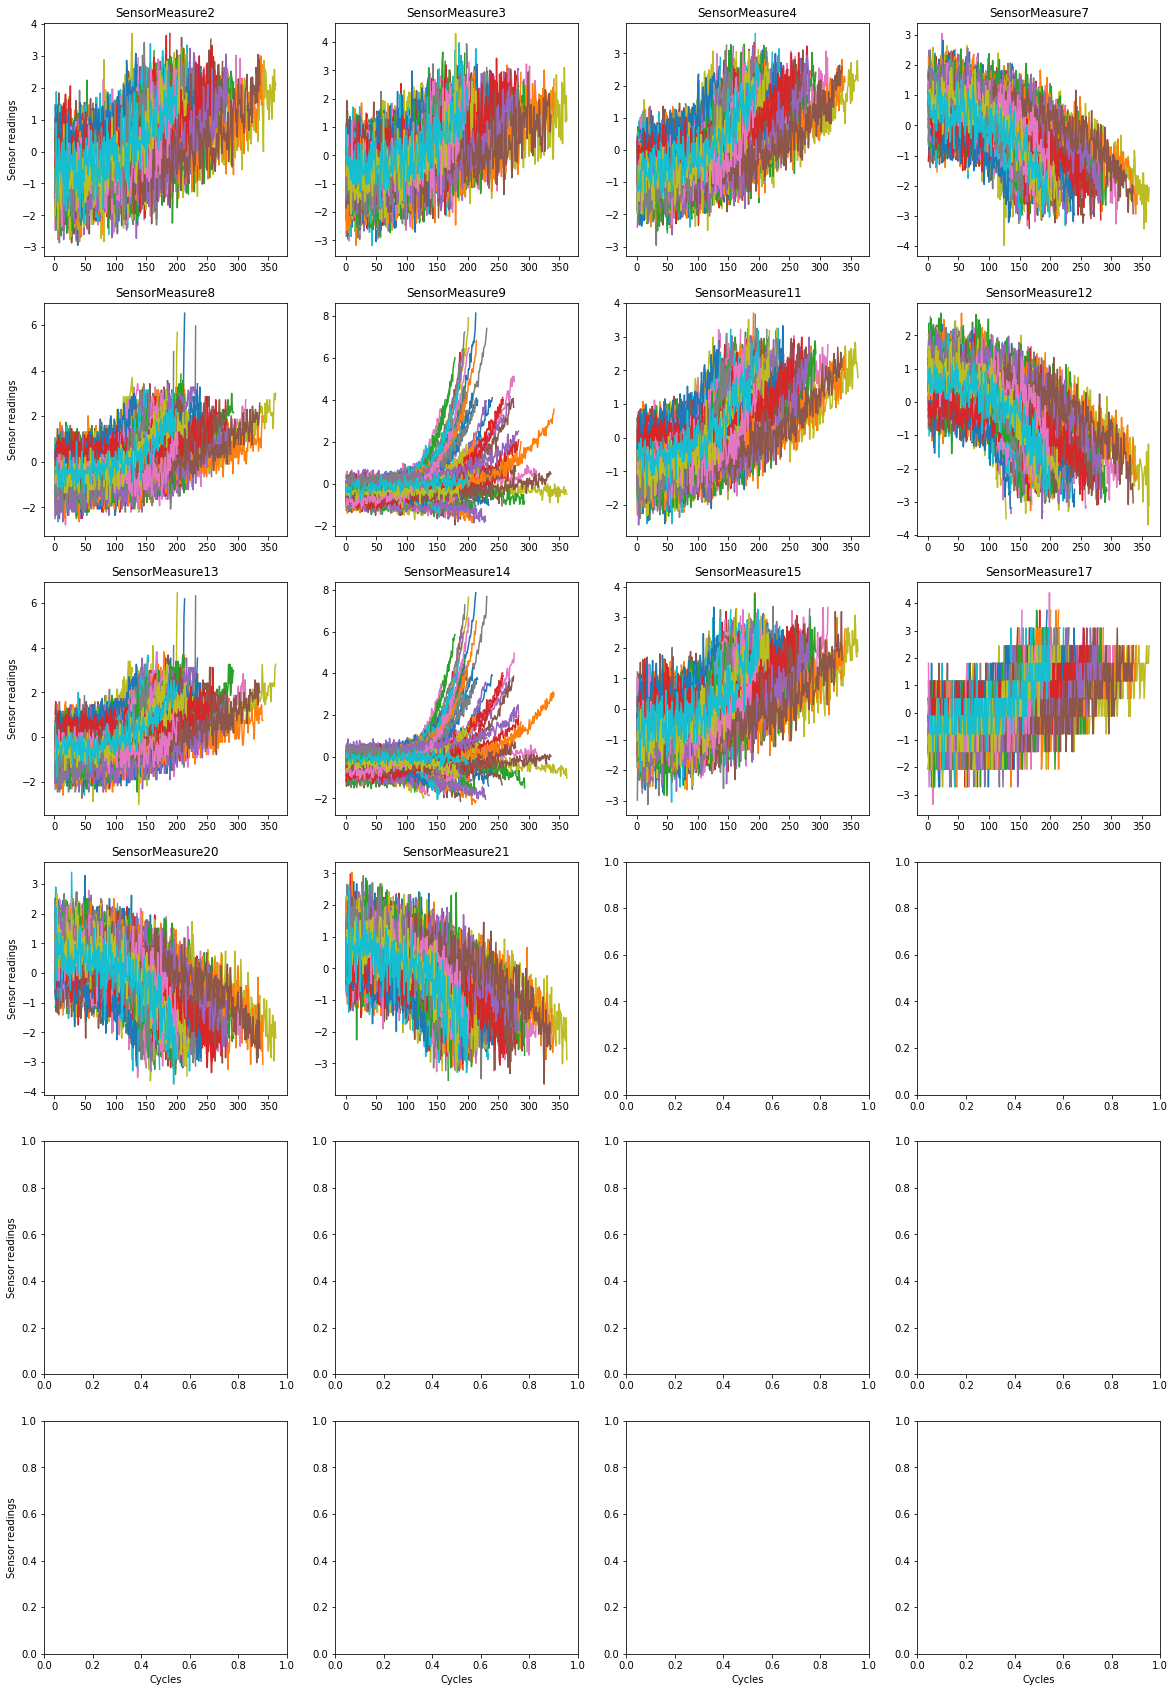

In [253]:
train_groupby = train_data_df.groupby(['ID'], sort=False)
plot_by_engine(train_groupby, 6, ms_used, 'fd001-sensors_scaled.jpg')

In [254]:
train_data_df.to_csv('./fd001-scaled_train.csv', sep=' ', columns=train_data_df.columns, index=False)
test_data_df[train_data_df.columns].to_csv('./fd001-scaled_test.csv', sep=' ', columns=train_data_df.columns, index=False)

### Smoothing curves

In [255]:
train_groupby = train_groupby[['ID', 'Cycle'] + ms_used]
test_groupby = test_groupby[['ID', 'Cycle'] + ms_used]
train_groupby.get_group(1)

ID  Cycle  SensorMeasure2  SensorMeasure3  SensorMeasure4  \
0     1      1       -1.721725       -0.134255       -0.925936   
1     1      2       -1.061780        0.211528       -0.643726   
2     1      3       -0.661813       -0.413166       -0.525953   
3     1      4       -0.661813       -1.261314       -0.784831   
4     1      5       -0.621816       -1.251528       -0.301518   
..   ..    ...             ...             ...             ...   
187   1    188        2.137957        1.933923        1.538403   
188   1    189        2.997886        0.921037        2.119489   
189   1    190        1.917975        1.418509        1.890610   
190   1    191        1.318024        1.930661        1.870611   
191   1    192        1.717992        1.775710        2.029493   

     SensorMeasure7  SensorMeasure8  SensorMeasure9  SensorMeasure11  \
0          1.121141       -0.516338       -0.862813        -0.266467   
1          0.431930       -0.798093       -0.958818        -0.191583   
2          1.008155       -0.234584       -0.557139        -1.015303   
3          1.222827        0.188048       -0.713826        -1.539489   
4          0.714393       -0.516338       -0.457059        -0.977861   
..              ...             ...             ...              ...   
187       -1.613104        3.005594       -1.237774         1.717951   
188       -3.014122        2.442085       -0.937081         2.017485   
189       -2.347508        2.723839       -1.116862         2.953531   
190       -2.765554        2.582962       -1.018141         2.279578   
191       -2.392703        3.146471       -1.450160         2.653997   

     SensorMeasure12  SensorMeasure13  SensorMeasure14  SensorMeasure15  \
0           0.334262        -1.058890        -0.269071        -0.603816   
1           1.174899        -0.363646        -0.642845        -0.275852   
2           1.364721        -0.919841        -0.551629        -0.649144   
3           1.961302        -0.224597        -0.520176        -1.971665   
4           1.052871        -0.780793        -0.521748        -0.339845   
..               ...              ...              ...              ...   
187        -2.201209         1.861136        -1.366278         2.094554   
188        -2.485941         3.251624        -1.375714         2.030561   
189        -1.862243         3.529722        -1.634158         2.137216   
190        -2.499500         2.834478        -1.527740         2.006564   
191        -1.808008         3.112575        -1.720655         1.843915   

     SensorMeasure17  SensorMeasure20  SensorMeasure21  
0          -0.781710         1.348493         1.194427  
1          -0.781710         1.016528         1.236922  
2          -2.073094         0.739891         0.503423  
3          -0.781710         0.352598         0.777792  
4          -0.136018         0.463253         1.059552  
..               ...              ...              ...  
187         1.801059        -1.694518        -3.056912  
188         1.155367        -1.860500        -1.635180  
189         3.092444        -1.805173        -2.052739  
190         0.509675        -2.026483        -1.479981  
191         1.801059        -1.860500        -3.000560  

[192 rows x 16 columns]

In [256]:
smoothing_columns = ['ID', 'Cycle'] + ms_used
train_groupby_arr = []
for i in range(len(train_groupby)):
    df = train_groupby.get_group(i+1).copy()
    lowess_df = df.copy()
    for sensor in range(2, len(smoothing_columns)):
        sn = smoothing_columns[sensor]
        lowess_df[sn] = pd.DataFrame(lowess(df[sn], np.arange(len(df[sn])), frac=0.25)[:, 1], index=df.index, columns=[sn])
    train_groupby_arr.append(lowess_df)

tr_joined_lowess_df = train_groupby_arr[0]
for i in range(1, len(train_groupby_arr)):
    tr_joined_lowess_df = pd.concat([tr_joined_lowess_df, train_groupby_arr[i]])

test_groupby_arr = []
for i in range(len(test_groupby)):
    df = test_groupby.get_group(i+1).copy()
    lowess_df = df.copy()
    for sensor in range(2, len(smoothing_columns)):
        sn = smoothing_columns[sensor]
        lowess_df[sn] = pd.DataFrame(lowess(df[sn], np.arange(len(df[sn])), frac=0.25)[:, 1], index=df.index, columns=[sn])
    test_groupby_arr.append(lowess_df)

test_joined_lowess_df = test_groupby_arr[0]
for i in range(1, len(test_groupby_arr)):
    test_joined_lowess_df = pd.concat([test_joined_lowess_df, test_groupby_arr[i]])

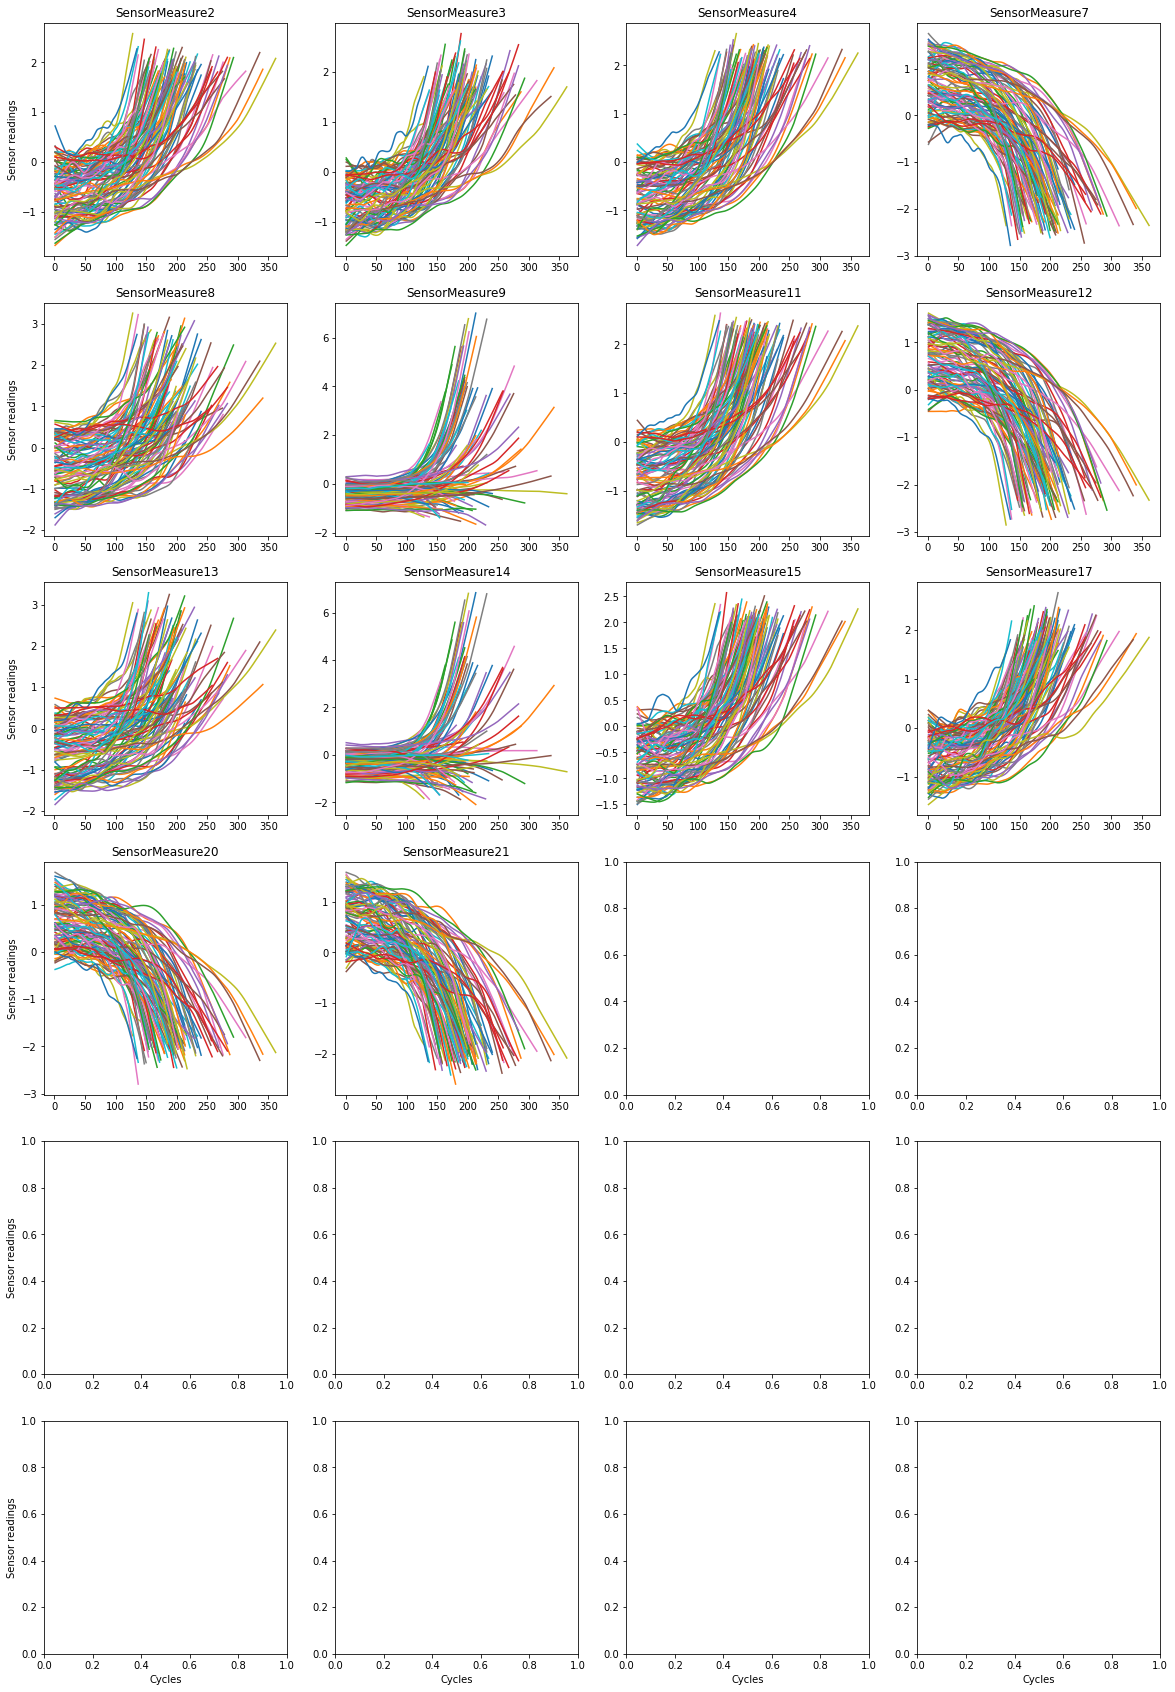

In [257]:
tr_joined_lowess_groupby = tr_joined_lowess_df.groupby(['ID'], sort = False)
plot_by_engine(tr_joined_lowess_groupby, 6, ms_used, 'fd001-sensors_smoothed.jpg')

In [258]:
tr_joined_lowess_df.to_csv('./fd001-smoothed_train.csv', sep=' ', columns=tr_joined_lowess_df.columns, index=False)
test_joined_lowess_df.to_csv('./fd001-smoothed_test.csv', sep=' ', columns=test_joined_lowess_df.columns, index=False)